In [1]:
import os
import numpy as np
from pathlib import Path
from gfos.data.utils import load_layout
from gfos.data.dataset import sample_configs


LAYOUT_DIR = r"H:\data\gfos\predict-ai-model-runtime\npz_all\npz\layout"
SOURCE = "xla"
SEARCH = "random"

In [2]:
files = load_layout(LAYOUT_DIR, model_type=SOURCE, compile_type=SEARCH)

In [3]:
train_val_file = files["train"] + files["valid"]

In [4]:
num_configs = [len(np.load(file)["config_runtime"]) for file in train_val_file]

In [13]:
max_configs = 9000
num_folds = 5
data_root = Path("../../data/indices")

data_root.mkdir(exist_ok=True)

In [19]:
for file in train_val_file:
    model_id = Path(file).stem
    npz = np.load(file)
    config_runtime = npz["config_runtime"]
    
    c = len(config_runtime)
    mc = min(max_configs, c) if max_configs > 0 else c
    third = max_configs // 3

    sorted_indices = np.argsort(config_runtime)
    for i in range(num_folds):
        if third * num_folds > c or 2 * (third * num_folds) > c:
            third = mc // 3
            keep_indices = np.concatenate(
                [
                    sorted_indices[:third],  # Good configs.
                    sorted_indices[-third:],  # Bad configs.
                    np.random.choice(
                        sorted_indices[third:-third],
                        mc - 2 * third,
                    ),
                ]
            )
        else:
            keep_indices = np.concatenate(
                [
                    np.random.choice(
                        sorted_indices[:third * num_folds],
                        third,
                    ), # Good configs.
                    np.random.choice(
                        sorted_indices[-third * num_folds:],
                        third,
                    ), # Bad configs.
                    np.random.choice(
                        sorted_indices[third * num_folds: -third * num_folds],
                        mc - 2 * third,
                    ),
                ]
            )

        fold_dir = data_root / f"{SOURCE}_{SEARCH}" / f"{i}"
        fold_dir.mkdir(exist_ok=True, parents=True)
        np.save(fold_dir / f"{model_id}.npy", keep_indices)


In [20]:
model = "alexnet_train_batch_32"
indices_folds = [np.load(data_root / f"{SOURCE}_{SEARCH}" / f"{i}" / f"{model}.npy") for i in range(num_folds)]


c:\Users\ntj_0\Anaconda3\envs\gfos\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ntj_0\Anaconda3\envs\gfos\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ntj_0\Anaconda3\envs\gfos\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ntj_0\Anaconda3\envs\gfos\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

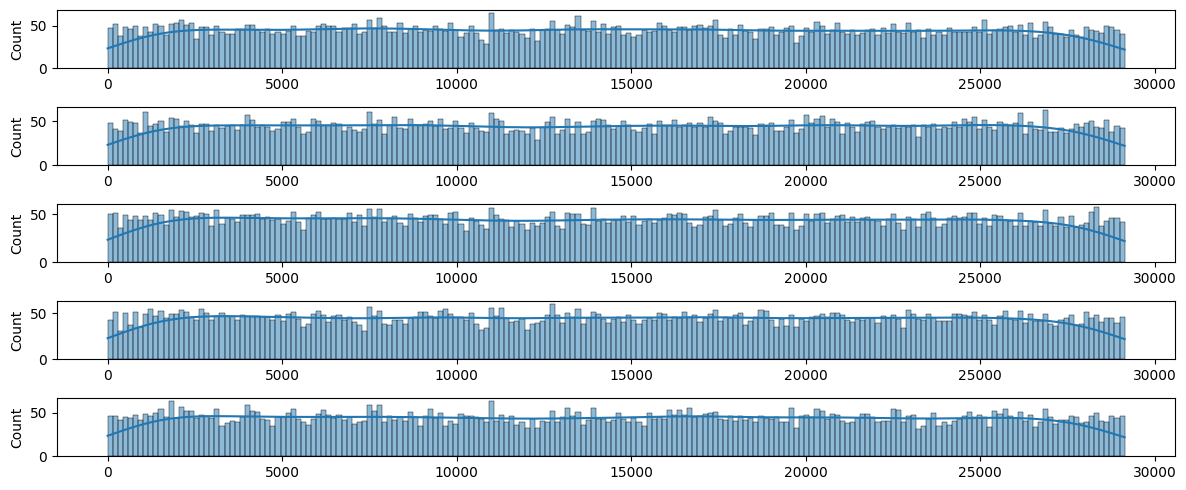

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

axes = plt.subplots(num_folds, 1, figsize=(12, 5))[1]
# plt.vlines(indices_fold1, 0, 1, color="red")
# plt.vlines(indices_fold2, 0, 1, color="green")
for i in range(num_folds):
    sns.histplot(indices_folds[i], kde=True, ax=axes[i], bins=200)

plt.tight_layout()